## Setup & Imports

In [1]:
import sys

sys.path.insert(0, "..")

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

from src.environment import InventoryEnvironment
from src.agents import AgentsLoader
from src.baseline import create_sS_policy
from src.mdp import RewardFunction
from src.simulation import InventorySimulation
from src.mdp import sample_initial_state
from src.seeds import generate_seeds

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Configuration

Set up baseline policy and list of agents to compare. Agent hyperparameters (k, Q_max) are loaded automatically.

In [2]:
SIM_DAYS = 1000  # Days per replication (about 3 years)
NUM_REPLICATIONS = 1000  # Number of independent runs

WELCH_SEEDS = generate_seeds(NUM_REPLICATIONS, start_index=0)

WINDOW_SIZE = 25

BASELINE_POLICY = create_sS_policy((20, 38), (19, 37))

print(f"📋 Configuration:")
print(f"   Simulation: {SIM_DAYS} days × {NUM_REPLICATIONS} replications")
print(f"   Smoothing window: {WINDOW_SIZE} days")

📋 Configuration:
   Simulation: 1000 days × 1000 replications
   Smoothing window: 25 days


## RL Agents Configuration

In [3]:
loader = AgentsLoader(models_dir=Path("./models"))

available_models = loader.list_available_models()
print(f"\n📦 Available trained models:")
for model in available_models:
    print(f"   • {model}")

# Select which RL agents to analyze
# Modify this list based on your trained models
RL_AGENTS = [
    "dqn_model_1",
    #"dqn_model",
    "ppo_model",
    #"dqn_Qmax30_baseline_agent",
]

print(f"\n🤖 RL Agents to analyze:")
for agent_name in RL_AGENTS:
    print(f"   • {agent_name}")


📦 Available trained models:
   • dqn_Qmax30_baseline_agent
   • dqn_k25_Qmax30_agent
   • dqn_k25_baseline_agent
   • dqn_k25_env_trainfreq2
   • dqn_model_0.01
   • dqn_model_1
   • dqn_model_k19
   • dqn_model_k25
   • ppo_final_best
   • ppo_model
   • ppo_model_1

🤖 RL Agents to analyze:
   • dqn_model_1
   • ppo_model


## 1. Baseline (s,S) Policy - Welch Analysis

In [4]:
print("=" * 80)
print("Running Baseline (s,S) Policy")
print("=" * 80)

baseline_costs = []
reward_fn = RewardFunction()

for seed in tqdm(WELCH_SEEDS, desc="Baseline replications"):
    rng = np.random.default_rng(seed)

    # Initialize simulation
    sim = InventorySimulation(random_state=rng)
    initial_state = sample_initial_state(steady_state=(11, 13), randomness=5, rng=rng)
    sim.reset(initial_state)

    daily_costs = []

    # Run simulation
    for _ in range(SIM_DAYS):
        state = sim.get_current_state()
        action = BASELINE_POLICY(state)
        new_state, _ = sim.execute_daily_decision(action)

        costs = reward_fn.calculate_costs(new_state, action)
        daily_costs.append(costs.total_cost)

    baseline_costs.append(daily_costs)

Running Baseline (s,S) Policy


Baseline replications: 100%|██████████| 1000/1000 [00:17<00:00, 58.74it/s]


## 2. RL Agents - Welch Analysis

In [5]:
def make_env(metadata, seed) -> InventoryEnvironment:
    return InventoryEnvironment(
        k=metadata["k"],
        Q_max=metadata["Q_max"],
        episode_length=SIM_DAYS,
        random_seed=seed,
    )


def run_default_env(metadata, agent, seed):
    eval_env = make_env(metadata=metadata, seed=seed)

    obs, _ = eval_env.reset()

    done = False
    while not done:
        action = agent.select_action(obs, deterministic=True)
        obs, _, terminated, truncated, _ = eval_env.step(action)

        done = terminated or truncated

    return eval_env.episode_costs

In [6]:
def run_norm_env(metadata, agent, seed):
    eval_env = DummyVecEnv([lambda: make_env(metadata=metadata, seed=seed)])

    eval_env = VecNormalize.load("./models/vec_normalize_ppo.pkl", eval_env)
    eval_env.training = False
    eval_env.norm_reward = False

    obs = eval_env.reset()
    daily_costs = []

    done = False
    while not done:
        action, _ = agent.model.predict(obs, deterministic=True)  # type: ignore

        obs, reward, done_vec, _ = eval_env.step(action)
        done = done_vec[0]

        daily_costs.append(float(-reward[0]))

    eval_env.close()
    return daily_costs

In [7]:
rl_agent_costs = {}

for agent_name in RL_AGENTS:
    print(f"\n{'='*80}")
    print(f"Running RL Agent: {agent_name}")
    print(f"{'='*80}")

    agent_type = agent_name.split("_")[0]

    agent, metadata = loader.load_agent(agent_name, agent_type=agent_type)

    print(f"Environment: k={metadata['k']}, Q_max={metadata['Q_max']}")

    agent_costs = []

    for seed in tqdm(WELCH_SEEDS, desc=f"{agent_name} replications"):

        if agent_type == "ppo":
            daily_costs = run_norm_env(metadata, agent, seed)
        elif agent_type == "dqn":
            daily_costs = run_default_env(metadata, agent, seed)

        agent_costs.append(daily_costs)

    rl_agent_costs[agent_name] = agent_costs

print(f"\n{'='*80}")
print(f"✅ All agents analyzed!")
print(f"{'='*80}")


Running RL Agent: dqn_model_1
📥 Loading DQN agent: dqn_model_1...
✅ Agent loaded successfully
Environment: k=30, Q_max=30


dqn_model_1 replications: 100%|██████████| 1000/1000 [02:00<00:00,  8.29it/s]



Running RL Agent: ppo_model
📥 Loading PPO agent: ppo_model...
✅ Agent loaded successfully
Environment: k=14, Q_max=30


ppo_model replications: 100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


✅ All agents analyzed!


## 3. Compute Average Daily Costs Across Replications

In [8]:
# Average across replications for baseline
baseline_avg_daily = [
    sum(day_costs) / NUM_REPLICATIONS for day_costs in zip(*baseline_costs)
]

# Average across replications for RL agents
rl_avg_daily = {}
for agent_name, costs in rl_agent_costs.items():
    rl_avg_daily[agent_name] = [
        sum(day_costs) / NUM_REPLICATIONS for day_costs in zip(*costs)
    ]

print(f"✅ Computed average daily costs across {NUM_REPLICATIONS} replications")

✅ Computed average daily costs across 1000 replications


## 4. Plot Raw Average Daily Costs

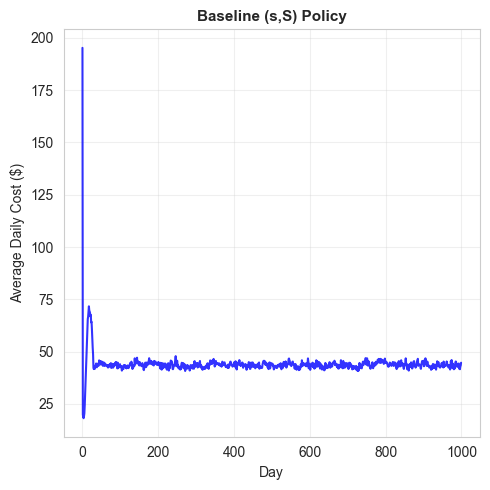

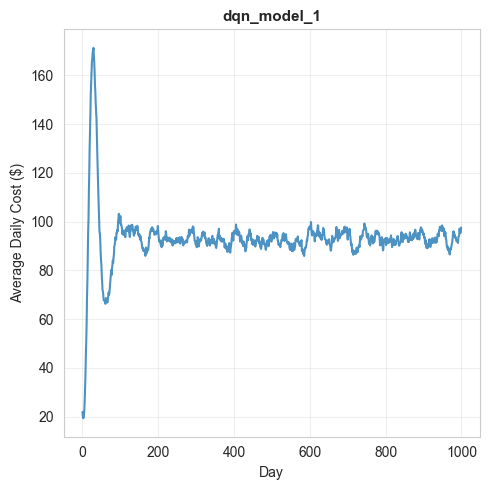

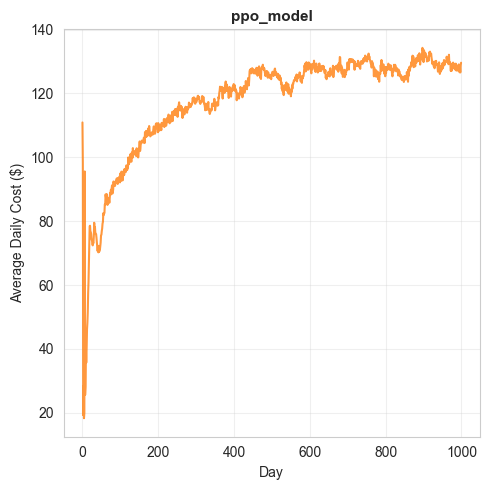

In [9]:
# Individual plots for detailed inspection
# Plot baseline
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(baseline_avg_daily, linewidth=1.5, alpha=0.8, color="blue")
ax.set_xlabel("Day", fontsize=10)
ax.set_ylabel("Average Daily Cost ($)", fontsize=10)
ax.set_title("Baseline (s,S) Policy", fontsize=11, fontweight="bold")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent separately
cmap = plt.colormaps.get_cmap("tab10")
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(5, 5))
    color = cmap(RL_AGENTS.index(agent_name) % cmap.N)
    ax.plot(rl_avg_daily[agent_name], linewidth=1.5, alpha=0.8, color=color)
    ax.set_xlabel("Day", fontsize=10)
    ax.set_ylabel("Average Daily Cost ($)", fontsize=10)
    ax.set_title(agent_name, fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Apply Moving Average (Welch's Smoothing)

In [10]:
def compute_moving_average(data: list[float], window_size: int) -> list[float]:
    """
    Compute centered moving average.

    Args:
        data: Daily cost values
        window_size: Half-width of window (total window = 2*window_size + 1)

    Returns:
        Smoothed values
    """
    moving_avg = []

    for i in range(len(data) - window_size):
        if i < window_size:
            # Use expanding window at start
            moving_avg.append(sum(data[: 2 * i + 1]) / (2 * i + 1))
        else:
            # Use full centered window
            window = data[i - window_size : i + window_size + 1]
            moving_avg.append(sum(window) / len(window))

    return moving_avg


# Apply smoothing
baseline_smoothed = compute_moving_average(baseline_avg_daily, WINDOW_SIZE)

rl_smoothed = {}
for agent_name in RL_AGENTS:
    rl_smoothed[agent_name] = compute_moving_average(
        rl_avg_daily[agent_name], WINDOW_SIZE
    )

print(f"✅ Applied moving average with window size {WINDOW_SIZE}")

✅ Applied moving average with window size 25


## 6. Plot Smoothed Curves (Welch Procedure)

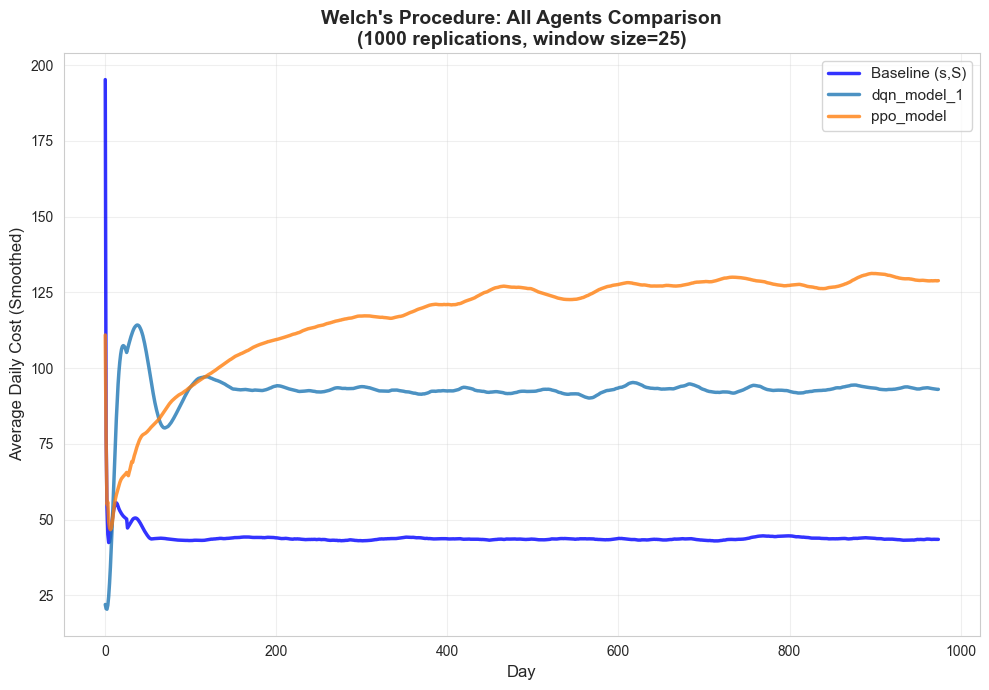

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot baseline
ax.plot(
    baseline_smoothed, label="Baseline (s,S)", linewidth=2.5, alpha=0.8, color="blue"
)

# Plot RL agents
for agent_name in RL_AGENTS:
    ax.plot(rl_smoothed[agent_name], label=agent_name, linewidth=2.5, alpha=0.8)

ax.set_xlabel("Day", fontsize=12)
ax.set_ylabel("Average Daily Cost (Smoothed)", fontsize=12)
ax.set_title(
    f"Welch's Procedure: All Agents Comparison\n"
    f"({NUM_REPLICATIONS} replications, window size={WINDOW_SIZE})",
    fontsize=14,
    fontweight="bold",
)
ax.legend(fontsize=11, loc="best")
ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

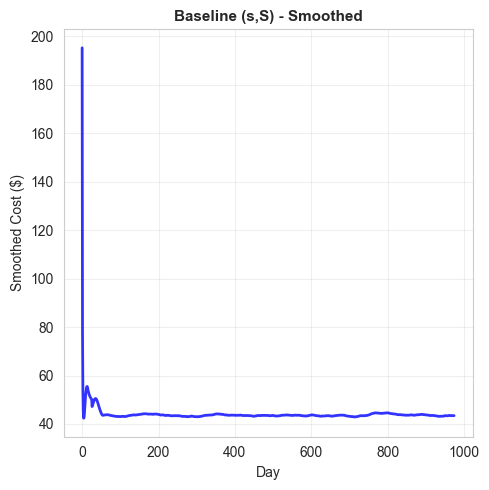

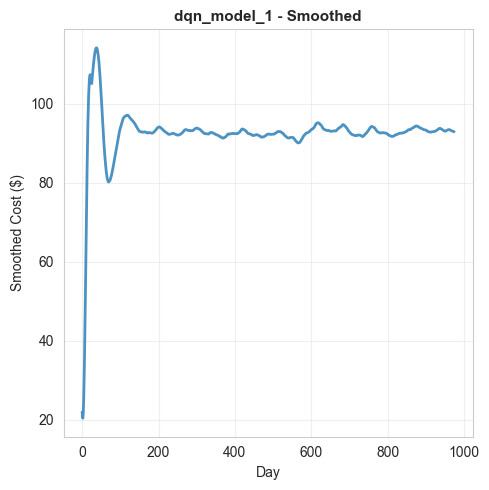

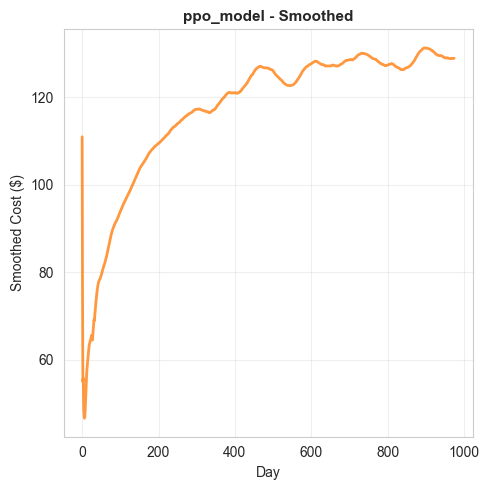

In [12]:
# Plot baseline
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(baseline_smoothed, linewidth=2, alpha=0.8, color="blue")
ax.set_xlabel("Day", fontsize=10)
ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
ax.set_title("Baseline (s,S) - Smoothed", fontsize=11, fontweight="bold")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent
cmap = plt.colormaps.get_cmap("tab10")
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(5, 5))
    color = cmap(RL_AGENTS.index(agent_name) % cmap.N)
    ax.plot(rl_smoothed[agent_name], linewidth=2, alpha=0.8, color=color)
    ax.set_xlabel("Day", fontsize=10)
    ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
    ax.set_title(f"{agent_name} - Smoothed", fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Automatic Warmup Detection

Use 5% tolerance algorithm to automatically detect warmup length.

In [13]:
def detect_warmup_length(smoothed_data: list[float], tolerance: float = 0.05) -> int:
    """
    Automatically detect warmup length using plateau detection.

    Args:
        smoothed_data: Smoothed daily cost curve
        tolerance: Relative tolerance for plateau (default: 5%)

    Returns:
        Warmup length in days
    """
    if len(smoothed_data) < 100:
        return len(smoothed_data) // 2

    # Use second half as steady-state estimate
    steady_state_start = len(smoothed_data) // 2
    steady_state_mean = np.mean(smoothed_data[steady_state_start:])
    threshold = tolerance * steady_state_mean

    # Find first point where cost stays within tolerance
    for i in range(50, len(smoothed_data) - 50):
        window = smoothed_data[i : i + 50]
        if all(abs(val - steady_state_mean) <= threshold for val in window):
            return i

    # Fallback
    return len(smoothed_data) // 2


# Detect warmup for all policies
baseline_warmup = detect_warmup_length(baseline_smoothed)

rl_warmups = {}
for agent_name in RL_AGENTS:
    rl_warmups[agent_name] = detect_warmup_length(rl_smoothed[agent_name])

print("🔍 Detected Warmup Lengths:")
print(f"   Baseline (s,S): {baseline_warmup} days")
for agent_name in RL_AGENTS:
    print(f"   {agent_name}: {rl_warmups[agent_name]} days")

🔍 Detected Warmup Lengths:
   Baseline (s,S): 50 days
   dqn_model_1: 89 days
   ppo_model: 413 days


## 8. Plot with Detected Warmup Periods

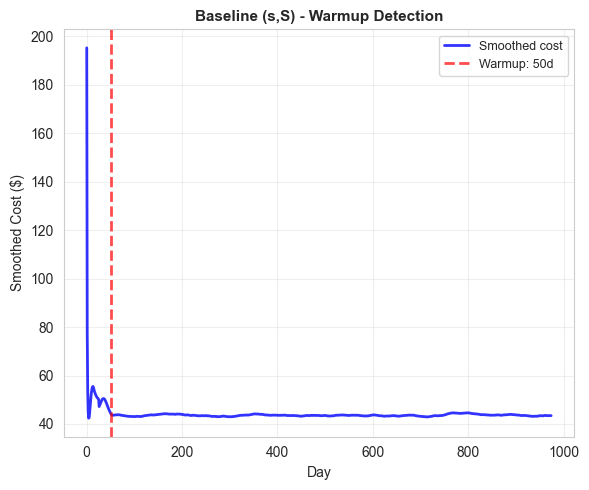

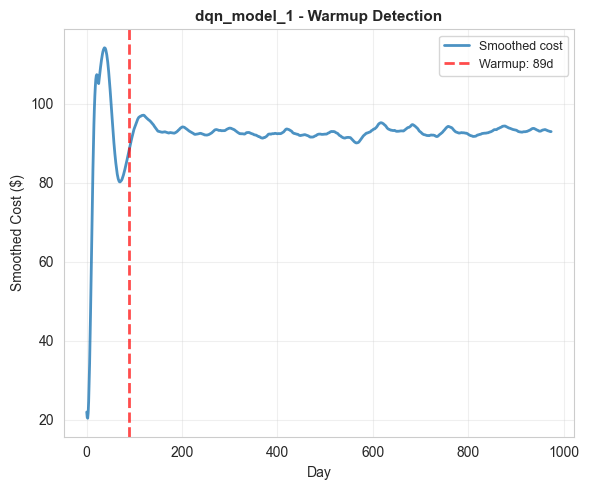

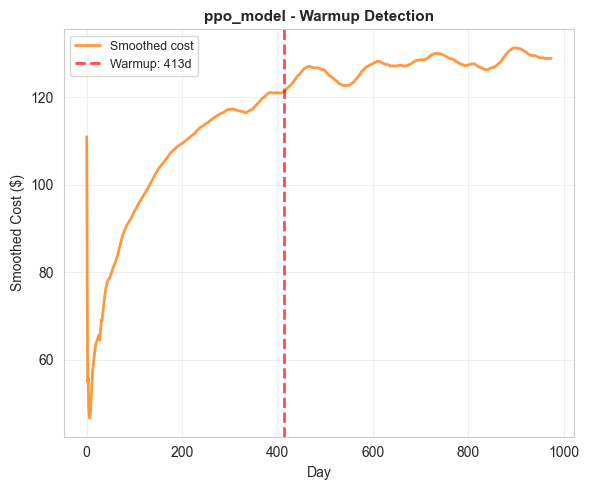

In [14]:
# Plot baseline with warmup
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(baseline_smoothed, linewidth=2, alpha=0.8, color="blue", label="Smoothed cost")
ax.axvline(
    baseline_warmup,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"Warmup: {baseline_warmup}d",
)
ax.set_xlabel("Day", fontsize=10)
ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
ax.set_title("Baseline (s,S) - Warmup Detection", fontsize=11, fontweight="bold")
ax.legend(fontsize=9, loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent with warmup
cmap = plt.colormaps.get_cmap("tab10")
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(6, 5))
    color = cmap(RL_AGENTS.index(agent_name) % cmap.N)
    ax.plot(
        rl_smoothed[agent_name],
        linewidth=2,
        alpha=0.8,
        color=color,
        label="Smoothed cost",
    )
    ax.axvline(
        rl_warmups[agent_name],
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label=f"Warmup: {rl_warmups[agent_name]}d",
    )
    ax.set_xlabel("Day", fontsize=10)
    ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
    ax.set_title(f"{agent_name} - Warmup Detection", fontsize=11, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Steady-State Cost Comparison

Compare performance after excluding warmup period.

In [15]:
def compute_steady_state_metrics(costs_data: list[list[float]], warmup: int) -> dict:
    """
    Compute steady-state cost metrics.

    Args:
        costs_data: [[day1, day2, ...], ...] for all replications
        warmup: Warmup period to exclude

    Returns:
        Dictionary with mean, std, ci_95
    """
    # Extract steady-state costs (after warmup) for each replication
    steady_state_costs = [np.mean(replication[warmup:]) for replication in costs_data]

    mean = np.mean(steady_state_costs)
    std = np.std(steady_state_costs)
    ci_95 = 1.96 * std / np.sqrt(len(steady_state_costs))

    return {
        "mean": mean,
        "std": std,
        "ci_95": ci_95,
        "per_replication": steady_state_costs,
    }


baseline_metrics = compute_steady_state_metrics(baseline_costs, baseline_warmup)

rl_metrics = {}
for agent_name in RL_AGENTS:
    rl_metrics[agent_name] = compute_steady_state_metrics(
        rl_agent_costs[agent_name], rl_warmups[agent_name]
    )


comparison_data = []

# Add baseline
comparison_data.append(
    {
        "Policy": "Baseline (s,S)",
        "Warmup (days)": baseline_warmup,
        "Mean Cost ($)": baseline_metrics["mean"],
        "Std ($)": baseline_metrics["std"],
        "95% CI (±$)": baseline_metrics["ci_95"],
        "vs Baseline (%)": 0.0,
    }
)

# Add RL agents
for agent_name in RL_AGENTS:
    metrics = rl_metrics[agent_name]
    improvement = (
        (baseline_metrics["mean"] - metrics["mean"]) / baseline_metrics["mean"]
    ) * 100

    comparison_data.append(
        {
            "Policy": agent_name,
            "Warmup (days)": rl_warmups[agent_name],
            "Mean Cost ($)": metrics["mean"],
            "Std ($)": metrics["std"],
            "95% CI (±$)": metrics["ci_95"],
            "vs Baseline (%)": improvement,
        }
    )

df_comparison = pd.DataFrame(comparison_data)

print("=" * 120)
print("STEADY-STATE COST COMPARISON (Welch's Procedure)")
print("=" * 120)

display(
    df_comparison.style.format(
        {
            "Mean Cost ($)": "{:.2f}",
            "Std ($)": "{:.2f}",
            "95% CI (±$)": "{:.2f}",
            "vs Baseline (%)": "{:+.2f}",
        }
    )
    .background_gradient(subset=["Mean Cost ($)"], cmap="RdYlGn_r")
    .background_gradient(subset=["vs Baseline (%)"], cmap="RdYlGn")
)

STEADY-STATE COST COMPARISON (Welch's Procedure)


,Policy,Warmup (days),Mean Cost ($),Std ($),95% CI (±$),vs Baseline (%)
0,"Baseline (s,S)",50,43.59,3.09,0.19,+0.00
1,dqn_model_1,89,93.06,8.07,0.50,-113.48
2,ppo_model,413,127.29,22.44,1.39,-192.01


## 10. Visualization: Cost Comparison

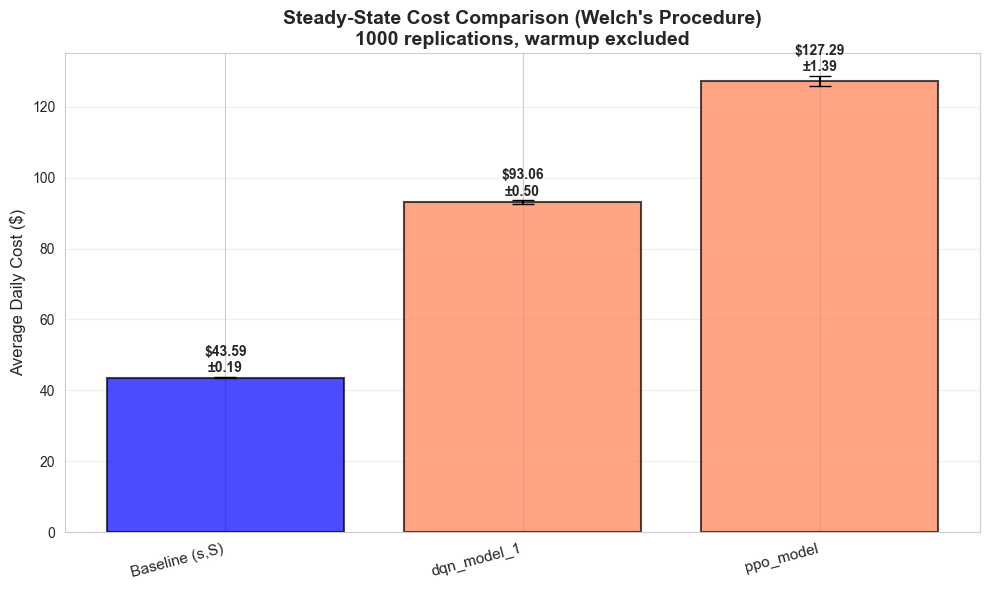

In [16]:
# Prepare data for visualization
policies = ['Baseline (s,S)'] + RL_AGENTS
means = [baseline_metrics['mean']] + [rl_metrics[name]['mean'] for name in RL_AGENTS]
cis = [baseline_metrics['ci_95']] + [rl_metrics[name]['ci_95'] for name in RL_AGENTS]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue'] + ['coral'] * len(RL_AGENTS)
bars = ax.bar(range(len(policies)), means, yerr=cis, 
              capsize=8, alpha=0.7, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(policies)))
ax.set_xticklabels(policies, fontsize=11, rotation=15, ha='right')
ax.set_ylabel('Average Daily Cost ($)', fontsize=12)
ax.set_title(
    'Steady-State Cost Comparison (Welch\'s Procedure)\n'
    f'{NUM_REPLICATIONS} replications, warmup excluded',
    fontsize=14, fontweight='bold'
)

# Add value labels on bars
for i, (mean, ci) in enumerate(zip(means, cis)):
    ax.text(i, mean + ci + 0.5, f'${mean:.2f}\n±{ci:.2f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 11. Export Results

In [17]:
export_data = {
    "configuration": {
        "sim_days": SIM_DAYS,
        "num_replications": NUM_REPLICATIONS,
        "window_size": WINDOW_SIZE,
        "seeds": [int(s) for s in WELCH_SEEDS],
    },
    "baseline": {
        "warmup_days": int(baseline_warmup),
        "steady_state_mean": float(baseline_metrics["mean"]),
        "steady_state_std": float(baseline_metrics["std"]),
        "steady_state_ci_95": float(baseline_metrics["ci_95"]),
    },
    "rl_agents": {},
}

for agent_name in RL_AGENTS:
    export_data["rl_agents"][agent_name] = {
        "warmup_days": int(rl_warmups[agent_name]),
        "steady_state_mean": float(rl_metrics[agent_name]["mean"]),
        "steady_state_std": float(rl_metrics[agent_name]["std"]),
        "steady_state_ci_95": float(rl_metrics[agent_name]["ci_95"]),
        "improvement_vs_baseline": float(
            (
                (baseline_metrics["mean"] - rl_metrics[agent_name]["mean"])
                / baseline_metrics["mean"]
            )
            * 100
        ),
    }


results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

output_path = results_dir / "welch_procedure_results.json"
with open(output_path, "w") as f:
    json.dump(export_data, f, indent=2)

print(f"✅ Results saved to: {output_path}")

✅ Results saved to: ../results/welch_procedure_results.json
